In [46]:
# First, we need to import all of the team player data and properly format it. 
bayern_raw = readcsv("Bayern Munich Player Stats.csv");
real_raw = readcsv("Real Madrid Player Stats.csv");
juv_raw = readcsv("Juventus Player Stats.csv");
barc_raw = readcsv("Barcelona Player Stats.csv");

real_squad_table = real_raw
bayern_squad_table = bayern_raw;
juv_squad_table = juv_raw;
barc_squad_table = barc_raw;

#We want some arrays that are purely the statistics, not things like names and such
squad_stat_values = real_squad_table[(2:26),(4:30)];
bay_stat_values = bayern_squad_table[(2:26),(4:30)];
juv_stat_values = juv_squad_table[(2:26),(4:30)];
barc_stat_values = barc_squad_table[(2:26),(4:30)];

#These constants are the columns for the stat arrays for different statistics. Done like this to make the parameters more readable
Acceleration = 1
Aggression = 2
Agility = 3
Balance = 4
Ball_Control = 5
Crossing = 6
Dribbling = 7
Finishing = 8
GK_Diving = 9
GK_Handling = 10
GK_Reflexes = 11
Heading_Accuracy = 12
Interceptions = 13
Long_Passing = 14
Long_Shots = 15
Marking = 16
Positioning = 17
Reactions = 18
Short_Passing = 19
Shotpower = 20
Sliding_Tackle = 21
Sprint_Speed = 22
Standing_Tackle = 23
Stamina = 24
Strength = 25
Vision = 26
Volleys = 27

In [52]:
#Team Composition Parameters. 
#These affect the minimum amount of each type of position we require
min_gks = 1
min_defense = 3
min_strikers = 1
min_midfielders = 2

#The norm constant is used in atan to determine where a score difference lies on the function. 
#The score difference is divided by the normalizing constant and then fed through atan
#The resulting number that is fed into atan will have less slope if greater than 2 or less than -2, 
#and increase in slope as it approaches 0
norm_constant = 50;

#This penalty is used to affect players who play immediately after their previous game. 
#Resting one game replenishes their stamina
base_stamina_penalty = 0.2

#These arrays affect which stats are relevant to each position.
gk = Array{Int64}(zeros(27))
gk[GK_Diving] = 1
gk[GK_Handling] = 1
gk[GK_Reflexes] = 1

def = Array{Int64}(zeros(27))
def[Aggression] = 1
def[Heading_Accuracy] = 1
def[Interceptions] = 1
def[Marking] = 1
def[Sliding_Tackle] = 1
def[Standing_Tackle] = 1
def[Strength] = 1

str = Array{Int64}(zeros(27))
str[Acceleration] = 1
str[Agility] = 1
str[Ball_Control] = 1
str[Dribbling] = 1
str[Finishing] = 1
str[Heading_Accuracy] = 1
str[Long_Shots] = 1
str[Positioning] = 1
str[Reactions] = 1
str[Shotpower] = 1
str[Sprint_Speed] = 1
str[Volleys] = 1

md_def = Array{Int64}(zeros(27))
md_def[Aggression] = 1
md_def[Heading_Accuracy] = 1
md_def[Interceptions] = 1
md_def[Marking] = 1
md_def[Sliding_Tackle] = 1
md_def[Standing_Tackle] = 1
md_def[Strength] = 1
md_off = Array{Int64}(zeros(27))
md_off[Acceleration] = 1
md_off[Agility] = 1
md_off[Balance] = 1
md_off[Ball_Control] = 1
md_off[Crossing] = 1
md_off[Dribbling] = 1
md_off[Finishing] = 1
md_off[Long_Passing] = 1
md_off[Short_Passing] = 1
md_off[Long_Shots] = 1
md_off[Positioning] = 1
md_off[Reactions] = 1
md_off[Shotpower] = 1
md_off[Sprint_Speed] = 1
md_off[Vision] = 1
md_off[Volleys] = 1

In [56]:
using JuMP, Mosek, DataFrames
#Pre-generate team stat arrays for each position
match_offense = Array{Float64}(zeros(4))
match_md_off = Array{Float64}(zeros(4))
match_md_def = Array{Float64}(zeros(4))
match_gk = Array{Float64}(zeros(4))
match_defense = Array{Float64}(zeros(4))
match_team_array = Array{Int64}(zeros(3,25,4))
for g in 1:3
    stat_values = Array{Int64}(zeros(25,27));
    squad_table = real_squad_table;
    #Choose the correct team for this game
    if g == 1
        stat_values = bay_stat_values;
        squad_table = bayern_squad_table;
    end
    if g == 2
        stat_values = juv_stat_values;
        squad_table = juv_squad_table;
    end
    if g == 3
        stat_values = barc_stat_values;
        squad_table = barc_squad_table;
    end
    #Filter the stat array into separate arrays for each position
    gk_vals = Array{Int64}(zeros(25,27))
    for i in 1:25
        gk_vals[i,:] = stat_values[i,:].*gk
    end
    def_vals = Array{Int64}(zeros(25,27))
    for i in 1:25
        def_vals[i,:] = stat_values[i,:].*def
    end
    str_vals = Array{Int64}(zeros(25,27))
    for i in 1:25
        str_vals[i,:] = stat_values[i,:].*str
    end
    md_def_vals = Array{Int64}(zeros(25,27))
    for i in 1:25
        md_def_vals[i,:] = stat_values[i,:].*md_def
    end
    md_off_vals = Array{Int64}(zeros(25,27))
    for i in 1:25
        md_off_vals[i,:] = stat_values[i,:].*md_off
    end
    #Positions are goalkeeper, defence, midfield, and striker
    #i is the game
    #j is the amount of players
    #k is the assignment of that player
    #We have five scores, and we choose the best combination to maximize the total score
    season = Model(solver=MosekSolver())
    @variable(season, team[1:1,1:25,1:4], Bin)
    @variable(season, offense_score[1:1] >= 0)
    @variable(season, defense_score[1:1] >= 0)
    @variable(season, md_off_score[1:1] >= 0)
    @variable(season, md_def_score[1:1] >= 0)
    @variable(season, gk_score[1:1] >= 0)
    for i in 1:1
        for j in 1:25
            #Restrict that a player can only be in one position
            @constraint(season, sum(team[i,j,:]) <= 1)
        end
    end
    for i in 1:1
        #11 players on a team
        @constraint(season, sum(team[i,:,:]) == 11)
        #Need minimimum for each position
        @constraint(season, sum(team[i,:,1]) == min_gks)
        @constraint(season, sum(team[i,:,2]) >= min_defense)
        @constraint(season, sum(team[i,:,3]) >= min_strikers)
        @constraint(season, sum(team[i,:,4]) >= min_midfielders)
        #Now, we determine the score by summing the values of those players that are in that position
        @constraint(season, defense_score[i] == sum(team[i,:,2]'*def_vals))
        @constraint(season, md_def_score[i] == sum(team[i,:,4]'*md_def_vals))
        @constraint(season, gk_score[i] == sum(team[i,:,1]'*gk_vals))
        @constraint(season, offense_score[i] == sum(team[i,:,3]'*str_vals))
        @constraint(season, md_off_score[i] == sum(team[i,:,4]'*md_off_vals))
    end
    @objective(season, Max, sum(offense_score) + sum(defense_score) + sum(md_def_score) + sum(md_off_score) + sum(gk_score))

    status = solve(season)
    println(status)
    
    #Now that we have solved it, print out the compositions
    season_comps = getvalue(team)
    offenses = getvalue(offense_score)
    md_offs = getvalue(md_off_score)
    md_defs = getvalue(md_def_score)
    gks = getvalue(gk_score)
    defenses = getvalue(defense_score)
    match_offense[g] = offenses[1]
    match_defense[g] = defenses[1]
    match_md_off[g] = md_offs[1]
    match_md_def[g] = md_defs[1]
    match_gk[g] = gks[1]
    comp = DataFrame(Player = String[], Position = String[], Assigned = String[], Team = String[])
    if g == 1
        display("Bayern Team Composition");
        team_name = "Bayern"
    end
    if g == 2
        display(" Juventus Team Composition");
        team_name = "Juventus"
    end
    if g == 3
        display(" Barcelona Team Composition");
        team_name = "Barcelona"
    end
    for i in 1:1
    for j in 1:25
        if season_comps[i,j,1] > 0.5
            push!(comp, [squad_table[j+1,1] squad_table[j+1,3] "Goalkeeper" team_name])
        end
    end
    for j in 1:25
        if season_comps[i,j,2] > 0.5
                push!(comp, [squad_table[j+1,1] squad_table[j+1,3] "Defender" team_name])
        end
    end
    for j in 1:25
        if season_comps[i,j,3] > 0.5
            push!(comp, [squad_table[j+1,1] squad_table[j+1,3] "Striker" team_name])
        end
    end
    for j in 1:25
        if season_comps[i,j,4] > 0.5
            push!(comp, [squad_table[j+1,1] squad_table[j+1,3] "Midfielder" team_name])
        end
    end
    display(comp);
end
end


"Bayern Team Composition"

,Player,Position,Assigned,Team
1,Manuel Neuer,GK,Goalkeeper,Bayern
2,Mats Hummels,CB,Defender,Bayern
3,Jerome Boateng,CB,Defender,Bayern
4,Javi Martinez,CM,Defender,Bayern
5,Robert Lewandowski,FW,Striker,Bayern
6,Juan Bernat,FB,Midfielder,Bayern
7,Philipp Lahm,FB,Midfielder,Bayern
8,David Alaba,FB,Midfielder,Bayern
9,Thiago Alcantara,CM,Midfielder,Bayern
10,Arturo Vidal,CM,Midfielder,Bayern


" Juventus Team Composition"

,Player,Position,Assigned,Team
1,Gianluigi Buffon,GK,Goalkeeper,Juventus
2,Giorgio Chiellini,CB,Defender,Juventus
3,Andrea Barzagli,CB,Defender,Juventus
4,Leonardo Bonucci,CB,Defender,Juventus
5,Paulo Dybala,FW,Striker,Juventus
6,Alex Sandro,FB,Midfielder,Juventus
7,Dani Alves,FB,Midfielder,Juventus
8,Miralem Pjanic,CM,Midfielder,Juventus
9,Sami Khedira,CM,Midfielder,Juventus
10,Claudio Marchisio,CM,Midfielder,Juventus


" Barcelona Team Composition"

,Player,Position,Assigned,Team
1,Marc-Andre Ter Stegen,GK,Goalkeeper,Barcelona
2,Gerard Pique,CB,Defender,Barcelona
3,Javier Mascherano,CB,Defender,Barcelona
4,Jeremy Mathieu,CB,Defender,Barcelona
5,Lionel Messi,FW,Striker,Barcelona
6,Jordi Alba,FB,Midfielder,Barcelona
7,Ivan Rakitic,CM,Midfielder,Barcelona
8,Arda Turan,WG,Midfielder,Barcelona
9,Andres Iniesta,CM,Midfielder,Barcelona
10,Andre Gomes,CM,Midfielder,Barcelona


Optimal
Optimal
Optimal


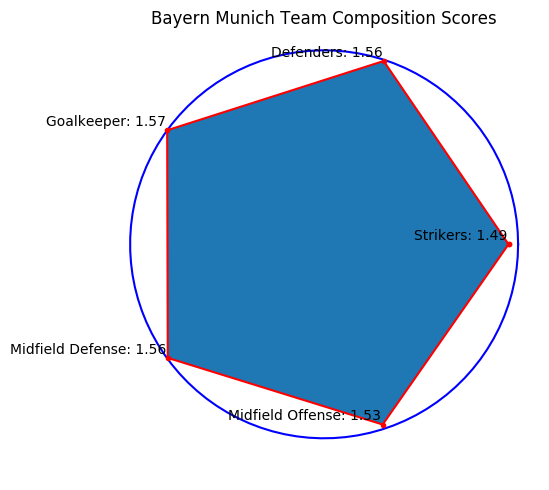

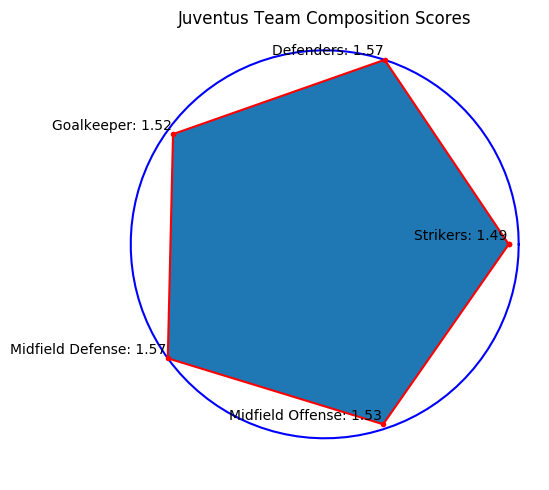

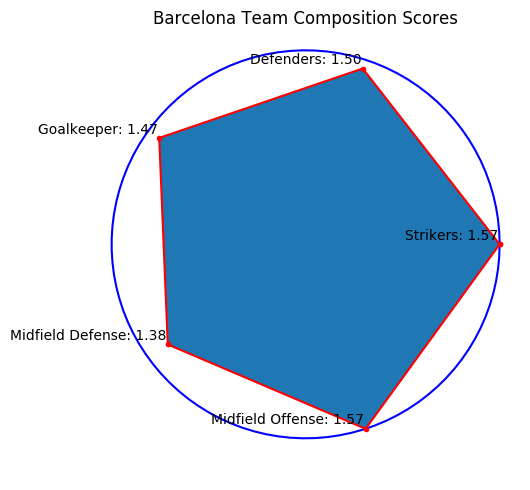

In [57]:
using PyPlot
#Visualize the scores of the teams
#first, find maxes
max_offense = 0
max_defense = 0
max_gk = 0
max_md_off = 0
max_md_def = 0
#Find the maximum values for each score
for i in 1:3
    if(match_offense[i] > max_offense)
        max_offense = match_offense[i]
    end
    if(match_defense[i] > max_defense)
        max_defense = match_defense[i]
    end
    if(match_gk[i] > max_gk)
        max_gk = match_gk[i]
    end
    if(match_md_off[i] > max_md_off)
        max_md_off = match_md_off[i]
    end
    if(match_md_def[i] > max_md_def)
        max_md_def = match_md_def[i]
    end
end
for i in 1:3
    #Set the radius equal to the ratio of the score of this team to max, multiplied by π/2
    #Why π/2? Because this is the maximum for the score difference in the model later!
    radii = Array{Float64}(zeros(6))
    radii[1] = (match_offense[i]/max_offense)*(π/2)
    radii[2] = (match_defense[i]/max_defense)*(π/2)
    radii[3] = (match_gk[i]/max_gk)*(π/2)
    radii[4] = (match_md_def[i]/max_md_def)*(π/2)
    radii[5] = (match_md_off[i]/max_md_off)*(π/2)
    radii[6] = (match_offense[i]/max_offense)*(π/2)
    angles = [0; 2π/5; 4π/5; 6π/5; 8π/5; 10π/5;]
    t = linspace(0,2π,100)
    figure(figsize=[5,5])
    plot( (π/2)*cos(t), (π/2)*sin(t), "b-" )
    plot( radii.*cos(angles), radii.*sin(angles), "r.-" )
    fill_between(radii.*cos(angles), 0, radii.*sin(angles))
    if i == 1
        title("Bayern Munich Team Composition Scores")
    end
    if i == 2
        title("Juventus Team Composition Scores")
    end
    if i == 3
        title("Barcelona Team Composition Scores")
    end
    label = ["Strikers", "Defenders", "Goalkeeper", "Midfield Defense", "Midfield Offense"]
    for j in 1:5
            annotate(label[j] * ": " * @sprintf("%.2f",radii[j]),
            xy=[radii[j]*cos(angles[j]); radii[j]*sin(angles[j])],
            xycoords = "data",
            xytext=[-1, 1],
        textcoords="offset points", ha="right", va="bottom")
        #arrowprops=["facecolor"=>"black"]);
    end
    axis("equal");axis("off");tight_layout();
end

In [60]:
stat_values = squad_stat_values;
squad_table = real_squad_table;
matches = 3
#Maximum score is π/2 * the number of different scores
max_limit = 5*π/2;
using AmplNLWriter
#You can remove the log statements here to track the progress. This does take time to solve!
season = Model(solver=BonminNLSolver(["bonmin.nlp_log_level=0"; "bonmin.bb_log_level=0"]))
#Generate the stat arrays
stamina = Array{Float64}(zeros(25))
for i in 1:25
    #This is the stamina penalty for playing again for a player. 
    #A perfect stat value score is 100, so a player with max stamina will suffer a base_stamina_penalty
    #A player with a stamina score of 50 will suffer (100/50) = 2*base_stamina_penalty
    stamina[i] = (100.0/stat_values[i,Stamina])*base_stamina_penalty
end
gk_vals = Array{Int64}(zeros(25,27))
for i in 1:25
    gk_vals[i,:] = stat_values[i,:].*gk
end
def_vals = Array{Int64}(zeros(25,27))
for i in 1:25
    def_vals[i,:] = stat_values[i,:].*def
end
str_vals = Array{Int64}(zeros(25,27))
for i in 1:25
    str_vals[i,:] = stat_values[i,:].*str
end
md_def_vals = Array{Int64}(zeros(25,27))
for i in 1:25
    md_def_vals[i,:] = stat_values[i,:].*md_def
end
md_off_vals = Array{Int64}(zeros(25,27))
for i in 1:25
    md_off_vals[i,:] = stat_values[i,:].*md_off
end
md_penalty = 1
#Positions are goalkeeper, defence, midfield, and striker
#i is the game
#j is the amount of players
#k is the assignment of that player
@variable(season, team[1:matches,1:25,1:4], Bin)
@variable(season, outcomes[1:matches], Bin)
for i in 1:matches
    for j in 1:25
        #A player can only be assigned to one position in a game
        @constraint(season, sum(team[i,j,:]) <= 1)
    end
    end
    for i in 1:matches
        #11 players on a team
        @constraint(season, sum(team[i,:,:]) == 11)
        #Need at least minimum for each position
        @constraint(season, sum(team[i,:,1]) == min_gks)
        #Must have some defenders and strikers
        @constraint(season, sum(team[i,:,2]) >= min_defense)
        @constraint(season, sum(team[i,:,3]) >= min_strikers)
        @constraint(season, sum(team[i,:,4]) >= min_midfielders)
    #Determine scores and result for the match    
    #This is done by summing the players in a position's stat values, setting that negative, then adding 
    #the opponent's opposite score, then adding a penalty if we played in the previous game too. 
    #The first game, however, has nothing before it. Our players are rested!
    #Then, this must be less than the max limit * the outcome for the game(binary). 
    #If this is positive, it forces the binary to 1. 
    if i == 1
        @NLconstraint(season, 
        atan((-sum(sum(team[i,j,3]*str_vals[j,k] for k=1:27) for j=1:25) + match_defense[i])/norm_constant) + 
        atan((-sum(sum(team[i,j,2]*def_vals[j,k] for k=1:27) for j=1:25) + match_offense[i])/norm_constant) + 
        atan((-sum(sum(team[i,j,4]*md_def_vals[j,k] for k=1:27) for j=1:25) + match_md_off[i])/norm_constant) + 
        atan((-sum(sum(team[i,j,4]*md_off_vals[j,k] for k=1:27) for j=1:25) + match_md_def[i])/norm_constant) + 
        atan((-sum(sum(team[i,j,1]*gk_vals[j,k] for k=1:27) for j=1:25) + match_gk[i])/norm_constant) <= max_limit*outcomes[i])
    else
       @NLconstraint(season, 
        atan((-sum(sum(team[i,j,3]*str_vals[j,k] for k=1:27)*(1-sum(team[i-1,j,l] for l=1:4)*stamina[j]) for j=1:25) + match_defense[i])/norm_constant) + 
        atan((-sum(sum(team[i,j,2]*def_vals[j,k] for k=1:27)*(1-sum(team[i-1,j,l] for l=1:4)*stamina[j]) for j=1:25)  + match_offense[i])/norm_constant) + 
        atan((-sum(sum(team[i,j,4]*md_def_vals[j,k] for k=1:27)*(1-sum(team[i-1,j,l] for l=1:4)*stamina[j])  for j=1:25) + match_md_off[i])/norm_constant) + 
        atan((-sum(sum(team[i,j,4]*md_off_vals[j,k] for k=1:27)*(1-sum(team[i-1,j,l] for l=1:4)*stamina[j])  for j=1:25) + match_md_def[i])/norm_constant) + 
        atan((-sum(sum(team[i,j,1]*gk_vals[j,k] for k=1:27)*(1-sum(team[i-1,j,l] for l=1:4)*stamina[j])  for j=1:25) + match_gk[i])/norm_constant) <= max_limit*outcomes[i])
    end
end

#Minimize the sum of outcomes. Each 1 is a lost game!
@NLobjective(season, Min, sum(outcomes[i] for i=1:matches))

status = solve(season)
println(status)

#Now that that is solved, print the team composition
season_comps = getvalue(team)
outcome = getvalue(outcomes)
println("We won ", (3-sum(outcome)), " games!")
for i in 1:matches
    comp = DataFrame(Player = String[], Position = String[], Assigned = String[])
    if g == 1
        display("Team Composition vs Bayern");
    end
    if g == 2
        display("Team Composition vs Juventus");
    end
    if g == 3
        display("Team Composition vs Barcelona");
    end
    for j in 1:25
        if season_comps[i,j,1] > 0.5
            push!(comp, [squad_table[j+1,1] squad_table[j+1,3] "Goalkeeper"])
        end
    end
    for j in 1:25
        if season_comps[i,j,2] > 0.5
                push!(comp, [squad_table[j+1,1] squad_table[j+1,3] "Defender"])
        end
    end
    for j in 1:25
        if season_comps[i,j,3] > 0.5
            push!(comp, [squad_table[j+1,1] squad_table[j+1,3] "Striker"])
        end
    end
    for j in 1:25
        if season_comps[i,j,4] > 0.5
            push!(comp, [squad_table[j+1,1] squad_table[j+1,3] "Midfielder"])
        end
    end
    display(comp);
end

Bonmin 1.8.1 using Cbc 2.9.2 and Ipopt 3.12.2
bonmin: bonmin.nlp_log_level=0
bonmin.bb_log_level=0


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 Very small infeasibility:  5.3290705e-015
 Very small infeasibility:  1.4210855e-014
 Very small infeasibility:  1.0658141e-014
 Very small infeasibility:  1.7763568e-015
 Very small infeasibility:  7.1054274e-015
 Very small infeasibility:  7.1054274e-015
 Very small infeasibility:  3.5527137e-015
 Very small infeasibility:  3.5527137e-015
 Very small infeasibility:  5.3290705e-015
 Very small infeasibility:  5.3290705e-015
 Very small infeasibility:  5.3290705e-015
 Very small infeasibility:  5.3290705e-

LoadError: syntax: incomplete: "for" at In[60]:92 requires end

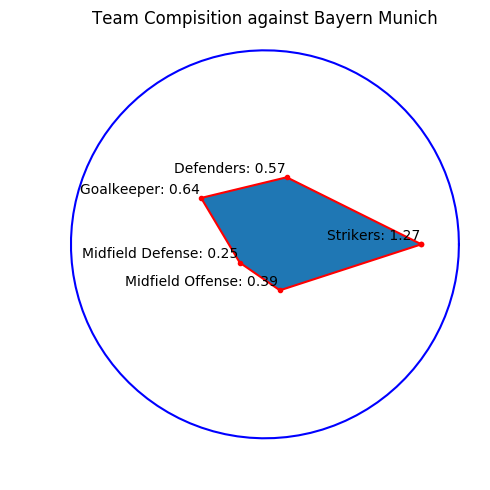

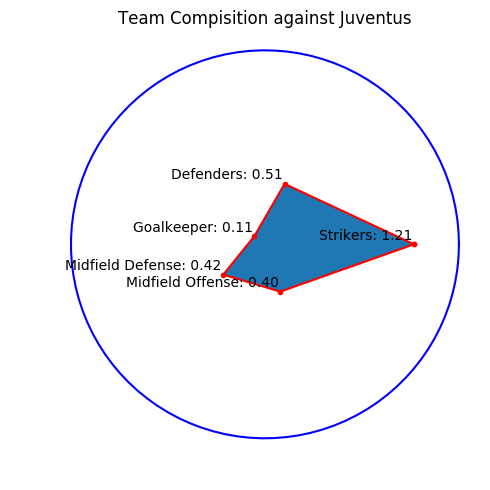

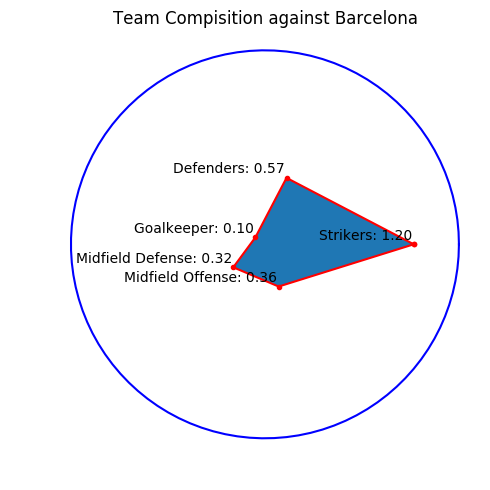

In [62]:
#Visualize the scores for each match
match_offenses = Array{Float64}(zeros(matches))
match_defenses = Array{Float64}(zeros(matches))
match_goalkeeper = Array{Float64}(zeros(matches))
match_md_offenses = Array{Float64}(zeros(matches))
match_md_defenses = Array{Float64}(zeros(matches))
for i in 1:matches
    #We omit including the scores as variables in the model to help with solving time, so the scores are given here instead
    if i == 1
    match_offenses[i] = atan((sum(sum(season_comps[i,j,3]*str_vals[j,:]) for j=1:25))/max_offense)
    match_defenses[i] = atan((sum(sum(season_comps[i,j,2]*def_vals[j,:]) for j=1:25))/max_defense)
    match_goalkeeper[i] = atan((sum(sum(season_comps[i,j,1]*gk_vals[j,:]) for j=1:25))/max_gk)
    match_md_offenses[i] = atan((sum(sum(season_comps[i,j,4]*md_off_vals[j,:]) for j=1:25))/max_md_off)
    match_md_defenses[i] = atan((sum(sum(season_comps[i,j,4]*md_def_vals[j,:]) for j=1:25))/max_md_def)
    else
    match_offenses[i] = atan((sum(sum(season_comps[i,j,3]*str_vals[j,:])*(1-sum(season_comps[i-1,j,l] for l=1:4)*stamina[j]) for j=1:25))/max_offense)
    match_defenses[i] = atan((sum(sum(season_comps[i,j,2]*def_vals[j,:])*(1-sum(season_comps[i-1,j,l] for l=1:4)*stamina[j]) for j=1:25))/max_defense)
    match_goalkeeper[i] = atan((sum(sum(season_comps[i,j,1]*gk_vals[j,:])*(1-sum(season_comps[i-1,j,l] for l=1:4)*stamina[j]) for j=1:25))/max_gk)
    match_md_offenses[i] = atan((sum(sum(season_comps[i,j,4]*md_off_vals[j,:])*(1-sum(season_comps[i-1,j,l] for l=1:4)*stamina[j]) for j=1:25))/max_md_off)
    match_md_defenses[i] = atan((sum(sum(season_comps[i,j,4]*md_def_vals[j,:])*(1-sum(season_comps[i-1,j,l] for l=1:4)*stamina[j]) for j=1:25))/max_md_def)
    end
end
for i in 1:matches
    radii = Array{Float64}(zeros(6))
    radii[1] = match_offenses[i]
    radii[2] = match_defenses[i]
    radii[3] = match_goalkeeper[i]
    radii[4] = match_md_defenses[i]
    radii[5] = match_md_offenses[i]
    radii[6] = match_offenses[i]
    angles = [0; 2π/5; 4π/5; 6π/5; 8π/5; 10π/5;]
    t = linspace(0,2π,100)
    figure(figsize=[5,5])
    plot( (π/2)*cos(t), (π/2)*sin(t), "b-" )
    plot( radii.*cos(angles), radii.*sin(angles), "r.-" )
    fill_between(radii.*cos(angles), 0, radii.*sin(angles))
    if i == 1
        title("Team Compisition against Bayern Munich")
    end
    if i == 2
        title("Team Compisition against Juventus")
    end
    if i == 3
        title("Team Compisition against Barcelona")
    end
    label = ["Strikers", "Defenders", "Goalkeeper", "Midfield Defense", "Midfield Offense"]
    for j in 1:5
            annotate(label[j] * ": " * @sprintf("%.2f",radii[j]),
            xy=[radii[j]*cos(angles[j]); radii[j]*sin(angles[j])],
            xycoords = "data",
            xytext=[-1, 1],
        textcoords="offset points", ha="right", va="bottom")
        #arrowprops=["facecolor"=>"black"]);
    end
    axis("equal");axis("off");tight_layout();
end

In [73]:
#This version respects that players should only be picked that qualify for that position

using JuMP, Mosek, DataFrames
#Pre-generate team stat arrays for each position
match_offense = Array{Float64}(zeros(4))
match_md_off = Array{Float64}(zeros(4))
match_md_def = Array{Float64}(zeros(4))
match_gk = Array{Float64}(zeros(4))
match_defense = Array{Float64}(zeros(4))
match_team_array = Array{Int64}(zeros(3,25,4))
for g in 1:3
    stat_values = Array{Int64}(zeros(25,27));
    squad_table = real_squad_table;
    #Choose the correct team for this game
    if g == 1
        stat_values = bay_stat_values;
        squad_table = bayern_squad_table;
    end
    if g == 2
        stat_values = juv_stat_values;
        squad_table = juv_squad_table;
    end
    if g == 3
        stat_values = barc_stat_values;
        squad_table = barc_squad_table;
    end
    #Filter the stat array into separate arrays for each position
    #Here is where we set values of people who cannot do that position to 0
    gk_vals = Array{Int64}(zeros(25,27))
    for i in 1:25
        if squad_table[i+1,3] == "GK"
            gk_vals[i,:] = stat_values[i,:].*gk
        else
            gk_vals[i,:] = stat_values[i,:].*(Array{Int64}(zeros(27)))
        end
    end
    def_vals = Array{Int64}(zeros(25,27))
    for i in 1:25
        if squad_table[i+1,3] == "CB" || squad_table[i+1,3] == "FB"
            def_vals[i,:] = stat_values[i,:].*def
        else
            def_vals[i,:] = stat_values[i,:].*(Array{Int64}(zeros(27)))
        end
    end
    str_vals = Array{Int64}(zeros(25,27))
    for i in 1:25
        if squad_table[i+1,3] == "FW"
            str_vals[i,:] = stat_values[i,:].*str
        else
            str_vals[i,:] = stat_values[i,:].*(Array{Int64}(zeros(27)))
        end
    end
    md_def_vals = Array{Int64}(zeros(25,27))
    for i in 1:25
        if squad_table[i+1,3] == "CM" || squad_table[i+1,3] == "WG"
            md_def_vals[i,:] = stat_values[i,:].*md_def
        else
            md_def_vals[i,:] = stat_values[i,:].*(Array{Int64}(zeros(27)))
        end
    end
    md_off_vals = Array{Int64}(zeros(25,27))
    for i in 1:25
        if squad_table[i+1,3] == "CM" || squad_table[i+1,3] == "WG"
            md_off_vals[i,:] = stat_values[i,:].*md_off
        else
            md_off_vals[i,:] = stat_values[i,:].*(Array{Int64}(zeros(27)))
        end
    end
    #Positions are goalkeeper, defence, midfield, and striker
    #i is the game
    #j is the amount of players
    #k is the assignment of that player
    #We have five scores, and we choose the best combination to maximize the total score
    season = Model(solver=MosekSolver())
    @variable(season, team[1:1,1:25,1:4], Bin)
    @variable(season, offense_score[1:1] >= 0)
    @variable(season, defense_score[1:1] >= 0)
    @variable(season, md_off_score[1:1] >= 0)
    @variable(season, md_def_score[1:1] >= 0)
    @variable(season, gk_score[1:1] >= 0)
    for i in 1:1
        for j in 1:25
            #Restrict that a player can only be in one position
            @constraint(season, sum(team[i,j,:]) <= 1)
        end
    end
    for i in 1:1
        #11 players on a team
        @constraint(season, sum(team[i,:,:]) == 11)
        #Need minimimum for each position
        @constraint(season, sum(team[i,:,1]) == min_gks)
        @constraint(season, sum(team[i,:,2]) >= min_defense)
        @constraint(season, sum(team[i,:,3]) >= min_strikers)
        @constraint(season, sum(team[i,:,4]) >= min_midfielders)
        #Now, we determine the score by summing the values of those players that are in that position
        @constraint(season, defense_score[i] == sum(team[i,:,2]'*def_vals))
        @constraint(season, md_def_score[i] == sum(team[i,:,4]'*md_def_vals))
        @constraint(season, gk_score[i] == sum(team[i,:,1]'*gk_vals))
        @constraint(season, offense_score[i] == sum(team[i,:,3]'*str_vals))
        @constraint(season, md_off_score[i] == sum(team[i,:,4]'*md_off_vals))
    end
    @objective(season, Max, sum(offense_score) + sum(defense_score) + sum(md_def_score) + sum(md_off_score) + sum(gk_score))

    status = solve(season)
    println(status)
    
    #Now that we have solved it, print out the compositions
    season_comps = getvalue(team)
    offenses = getvalue(offense_score)
    md_offs = getvalue(md_off_score)
    md_defs = getvalue(md_def_score)
    gks = getvalue(gk_score)
    defenses = getvalue(defense_score)
    match_offense[g] = offenses[1]
    match_defense[g] = defenses[1]
    match_md_off[g] = md_offs[1]
    match_md_def[g] = md_defs[1]
    match_gk[g] = gks[1]
    comp = DataFrame(Player = String[], Position = String[], Assigned = String[], Team = String[])
    if g == 1
        display("Bayern Team Composition");
        team_name = "Bayern"
    end
    if g == 2
        display(" Juventus Team Composition");
        team_name = "Juventus"
    end
    if g == 3
        display(" Barcelona Team Composition");
        team_name = "Barcelona"
    end
    for i in 1:1
    for j in 1:25
        if season_comps[i,j,1] > 0.5
            push!(comp, [squad_table[j+1,1] squad_table[j+1,3] "Goalkeeper" team_name])
        end
    end
    for j in 1:25
        if season_comps[i,j,2] > 0.5
                push!(comp, [squad_table[j+1,1] squad_table[j+1,3] "Defender" team_name])
        end
    end
    for j in 1:25
        if season_comps[i,j,3] > 0.5
            push!(comp, [squad_table[j+1,1] squad_table[j+1,3] "Striker" team_name])
        end
    end
    for j in 1:25
        if season_comps[i,j,4] > 0.5
            push!(comp, [squad_table[j+1,1] squad_table[j+1,3] "Midfielder" team_name])
        end
    end
    display(comp);
end
end


"Bayern Team Composition"

,Player,Position,Assigned,Team
1,Manuel Neuer,GK,Goalkeeper,Bayern
2,Mats Hummels,CB,Defender,Bayern
3,Jerome Boateng,CB,Defender,Bayern
4,Holger Badstuber,CB,Defender,Bayern
5,Robert Lewandowski,FW,Striker,Bayern
6,Joshua Kimmich,CM,Midfielder,Bayern
7,Thiago Alcantara,CM,Midfielder,Bayern
8,Douglas Costa,WG,Midfielder,Bayern
9,Xabi Alonso,CM,Midfielder,Bayern
10,Arturo Vidal,CM,Midfielder,Bayern


" Juventus Team Composition"

,Player,Position,Assigned,Team
1,Gianluigi Buffon,GK,Goalkeeper,Juventus
2,Giorgio Chiellini,CB,Defender,Juventus
3,Andrea Barzagli,CB,Defender,Juventus
4,Leonardo Bonucci,CB,Defender,Juventus
5,Paulo Dybala,FW,Striker,Juventus
6,Miralem Pjanic,CM,Midfielder,Juventus
7,Sami Khedira,CM,Midfielder,Juventus
8,Claudio Marchisio,CM,Midfielder,Juventus
9,Mario Lemina,CM,Midfielder,Juventus
10,Kwadwo Asamoah,WG,Midfielder,Juventus


" Barcelona Team Composition"

,Player,Position,Assigned,Team
1,Marc-Andre Ter Stegen,GK,Goalkeeper,Barcelona
2,Gerard Pique,CB,Defender,Barcelona
3,Javier Mascherano,CB,Defender,Barcelona
4,Jeremy Mathieu,CB,Defender,Barcelona
5,Lionel Messi,FW,Striker,Barcelona
6,Ivan Rakitic,CM,Midfielder,Barcelona
7,Sergio Busquets,CM,Midfielder,Barcelona
8,Arda Turan,WG,Midfielder,Barcelona
9,Andres Iniesta,CM,Midfielder,Barcelona
10,Rafinha,WG,Midfielder,Barcelona


Optimal
Optimal
Optimal


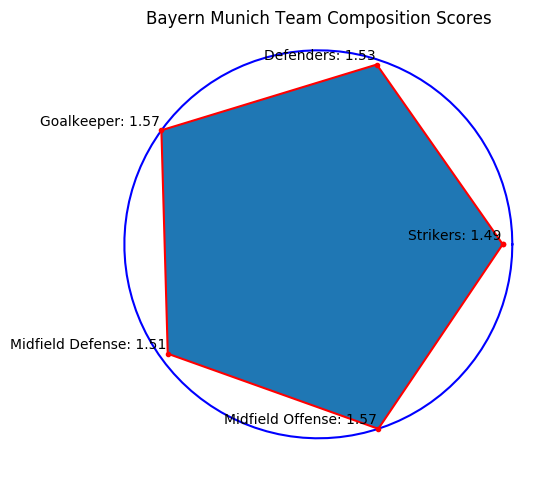

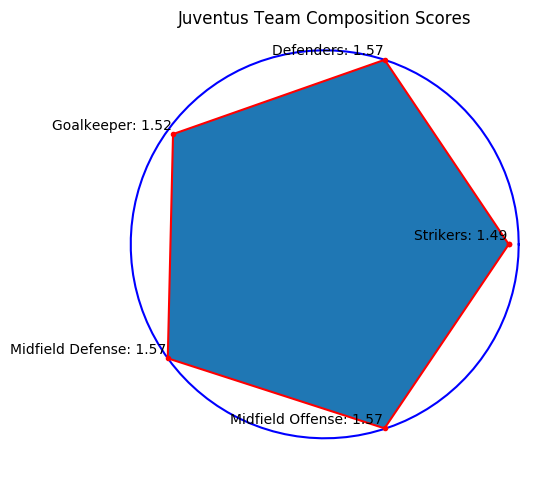

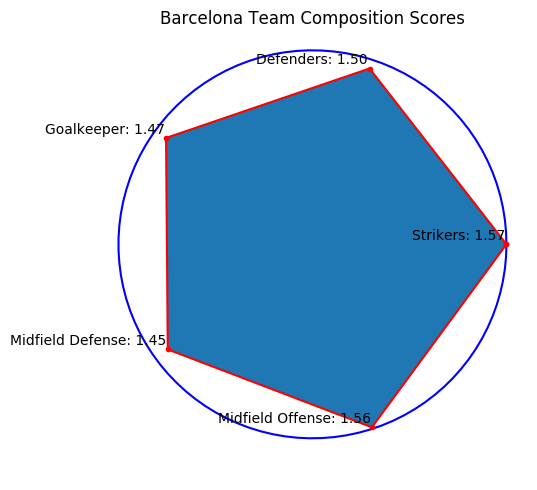

In [74]:
using PyPlot
#Visualize the scores of the teams
#first, find maxes
max_offense = 0
max_defense = 0
max_gk = 0
max_md_off = 0
max_md_def = 0
#Find the maximum values for each score
for i in 1:3
    if(match_offense[i] > max_offense)
        max_offense = match_offense[i]
    end
    if(match_defense[i] > max_defense)
        max_defense = match_defense[i]
    end
    if(match_gk[i] > max_gk)
        max_gk = match_gk[i]
    end
    if(match_md_off[i] > max_md_off)
        max_md_off = match_md_off[i]
    end
    if(match_md_def[i] > max_md_def)
        max_md_def = match_md_def[i]
    end
end
for i in 1:3
    #Set the radius equal to the ratio of the score of this team to max, multiplied by π/2
    #Why π/2? Because this is the maximum for the score difference in the model later!
    radii = Array{Float64}(zeros(6))
    radii[1] = (match_offense[i]/max_offense)*(π/2)
    radii[2] = (match_defense[i]/max_defense)*(π/2)
    radii[3] = (match_gk[i]/max_gk)*(π/2)
    radii[4] = (match_md_def[i]/max_md_def)*(π/2)
    radii[5] = (match_md_off[i]/max_md_off)*(π/2)
    radii[6] = (match_offense[i]/max_offense)*(π/2)
    angles = [0; 2π/5; 4π/5; 6π/5; 8π/5; 10π/5;]
    t = linspace(0,2π,100)
    figure(figsize=[5,5])
    plot( (π/2)*cos(t), (π/2)*sin(t), "b-" )
    plot( radii.*cos(angles), radii.*sin(angles), "r.-" )
    fill_between(radii.*cos(angles), 0, radii.*sin(angles))
    if i == 1
        title("Bayern Munich Team Composition Scores")
    end
    if i == 2
        title("Juventus Team Composition Scores")
    end
    if i == 3
        title("Barcelona Team Composition Scores")
    end
    label = ["Strikers", "Defenders", "Goalkeeper", "Midfield Defense", "Midfield Offense"]
    for j in 1:5
            annotate(label[j] * ": " * @sprintf("%.2f",radii[j]),
            xy=[radii[j]*cos(angles[j]); radii[j]*sin(angles[j])],
            xycoords = "data",
            xytext=[-1, 1],
        textcoords="offset points", ha="right", va="bottom")
        #arrowprops=["facecolor"=>"black"]);
    end
    axis("equal");axis("off");tight_layout();
end

In [79]:
stat_values = squad_stat_values;
squad_table = real_squad_table;
matches = 3
#Maximum score is π/2 * the number of different scores
max_limit = 5*π/2;
using AmplNLWriter
#You can remove the log statements here to track the progress. This does take time to solve!
season = Model(solver=BonminNLSolver(["bonmin.nlp_log_level=0"; "bonmin.bb_log_level=0"]))
#Generate the stat arrays
stamina = Array{Float64}(zeros(25))
for i in 1:25
    #This is the stamina penalty for playing again for a player. 
    #A perfect stat value score is 100, so a player with max stamina will suffer a base_stamina_penalty
    #A player with a stamina score of 50 will suffer (100/50) = 2*base_stamina_penalty
    stamina[i] = (100.0/stat_values[i,Stamina])*base_stamina_penalty
end
gk_vals = Array{Int64}(zeros(25,27))
for i in 1:25
    if squad_table[i+1,3] == "GK"
        gk_vals[i,:] = stat_values[i,:].*gk
    else
        gk_vals[i,:] = stat_values[i,:].*(Array{Int64}(zeros(27)))
    end
end
def_vals = Array{Int64}(zeros(25,27))
for i in 1:25
    if squad_table[i+1,3] == "CB" || squad_table[i+1,3] == "FB"
        def_vals[i,:] = stat_values[i,:].*def
    else
        def_vals[i,:] = stat_values[i,:].*(Array{Int64}(zeros(27)))
    end
end
str_vals = Array{Int64}(zeros(25,27))
for i in 1:25
    if squad_table[i+1,3] == "FW"
        str_vals[i,:] = stat_values[i,:].*str
    else
        str_vals[i,:] = stat_values[i,:].*(Array{Int64}(zeros(27)))
    end
end
md_def_vals = Array{Int64}(zeros(25,27))
for i in 1:25
    if squad_table[i+1,3] == "CM" || squad_table[i+1,3] == "WG"
        md_def_vals[i,:] = stat_values[i,:].*md_def
    else
        md_def_vals[i,:] = stat_values[i,:].*(Array{Int64}(zeros(27)))
    end
end
md_off_vals = Array{Int64}(zeros(25,27))
for i in 1:25
    if squad_table[i+1,3] == "CM" || squad_table[i+1,3] == "WG"
        md_off_vals[i,:] = stat_values[i,:].*md_off
    else
        md_off_vals[i,:] = stat_values[i,:].*(Array{Int64}(zeros(27)))
    end
end
#Positions are goalkeeper, defence, midfield, and striker
#i is the game
#j is the amount of players
#k is the assignment of that player
@variable(season, team[1:matches,1:25,1:4], Bin)
@variable(season, outcomes[1:matches], Bin)
for i in 1:matches
    for j in 1:25
        #A player can only be assigned to one position in a game
        @constraint(season, sum(team[i,j,:]) <= 1)
    end
end
for i in 1:matches
    #11 players on a team
    @constraint(season, sum(team[i,:,:]) == 11)
    #Need at least minimum for each position
    @constraint(season, sum(team[i,:,1]) == min_gks)
    #Must have some defenders and strikers
    @constraint(season, sum(team[i,:,2]) >= min_defense)
    @constraint(season, sum(team[i,:,3]) >= min_strikers)
    @constraint(season, sum(team[i,:,4]) >= min_midfielders)
    #Determine scores and result for the match    
    #This is done by summing the players in a position's stat values, setting that negative, then adding 
    #the opponent's opposite score, then adding a penalty if we played in the previous game too. 
    #The first game, however, has nothing before it. Our players are rested!
    #Then, this must be less than the max limit * the outcome for the game(binary). 
    #If this is positive, it forces the binary to 1. 
    #Also, since some of our scores are zero, make sure someone in a position actually has a score for that position
    for j in 1:25
        @NLconstraint(season, sum(team[i,j,3]*str_vals[j,k] for k=1:27) >= team[i,j,3])
        @NLconstraint(season, sum(team[i,j,2]*def_vals[j,k] for k=1:27) >= team[i,j,2])
        @NLconstraint(season, sum(team[i,j,4]*md_def_vals[j,k] for k=1:27) >= team[i,j,4])
        @NLconstraint(season, sum(team[i,j,4]*md_off_vals[j,k] for k=1:27) >= team[i,j,4])
        @NLconstraint(season, sum(team[i,j,1]*gk_vals[j,k] for k=1:27) >= team[i,j,1])
    end
    if i == 1
        @NLconstraint(season, 
        atan((-sum(sum(team[i,j,3]*str_vals[j,k] for k=1:27) for j=1:25) + match_defense[i])/norm_constant) + 
        atan((-sum(sum(team[i,j,2]*def_vals[j,k] for k=1:27) for j=1:25) + match_offense[i])/norm_constant) + 
        atan((-sum(sum(team[i,j,4]*md_def_vals[j,k] for k=1:27) for j=1:25) + match_md_off[i])/norm_constant) + 
        atan((-sum(sum(team[i,j,4]*md_off_vals[j,k] for k=1:27) for j=1:25) + match_md_def[i])/norm_constant) + 
        atan((-sum(sum(team[i,j,1]*gk_vals[j,k] for k=1:27) for j=1:25) + match_gk[i])/norm_constant) <= max_limit*outcomes[i])
    else
       @NLconstraint(season, 
        atan((-sum(sum(team[i,j,3]*str_vals[j,k] for k=1:27)*(1-sum(team[i-1,j,l] for l=1:4)*stamina[j]) for j=1:25) + match_defense[i])/norm_constant) + 
        atan((-sum(sum(team[i,j,2]*def_vals[j,k] for k=1:27)*(1-sum(team[i-1,j,l] for l=1:4)*stamina[j]) for j=1:25)  + match_offense[i])/norm_constant) + 
        atan((-sum(sum(team[i,j,4]*md_def_vals[j,k] for k=1:27)*(1-sum(team[i-1,j,l] for l=1:4)*stamina[j])  for j=1:25) + match_md_off[i])/norm_constant) + 
        atan((-sum(sum(team[i,j,4]*md_off_vals[j,k] for k=1:27)*(1-sum(team[i-1,j,l] for l=1:4)*stamina[j])  for j=1:25) + match_md_def[i])/norm_constant) + 
        atan((-sum(sum(team[i,j,1]*gk_vals[j,k] for k=1:27)*(1-sum(team[i-1,j,l] for l=1:4)*stamina[j])  for j=1:25) + match_gk[i])/norm_constant) <= max_limit*outcomes[i])
    end
end

#Minimize the sum of outcomes. Each 1 is a lost game!
@NLobjective(season, Min, sum(outcomes[i] for i=1:matches))

status = solve(season)
display(status)

#Now that that is solved, print the team composition
season_comps = getvalue(team)
outcome = getvalue(outcomes)
println("We won ", (3-sum(outcome)), " games!")
for i in 1:matches
    comp = DataFrame(Player = String[], Position = String[], Assigned = String[])
    if i == 1
        display("Team Composition vs Bayern");
    end
    if i == 2
        display("Team Composition vs Juventus");
    end
    if i == 3
        display("Team Composition vs Barcelona");
    end
    for j in 1:25
        if season_comps[i,j,1] > 0.5
            push!(comp, [squad_table[j+1,1] squad_table[j+1,3] "Goalkeeper"])
        end
    end
    for j in 1:25
        if season_comps[i,j,2] > 0.5
                push!(comp, [squad_table[j+1,1] squad_table[j+1,3] "Defender"])
        end
    end
    for j in 1:25
        if season_comps[i,j,3] > 0.5
            push!(comp, [squad_table[j+1,1] squad_table[j+1,3] "Striker"])
        end
    end
    for j in 1:25
        if season_comps[i,j,4] > 0.5
            push!(comp, [squad_table[j+1,1] squad_table[j+1,3] "Midfielder"])
        end
    end
    display(comp);
end

Bonmin 1.8.1 using Cbc 2.9.2 and Ipopt 3.12.2
bonmin: bonmin.nlp_log_level=0
bonmin.bb_log_level=0


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



:Optimal

"Team Composition vs Bayern"

,Player,Position,Assigned
1,Keylor Navas,GK,Goalkeeper
2,Pepe,CB,Defender
3,Sergio Ramos,CB,Defender
4,Raphael Varane,CB,Defender
5,Karim Benzema,FW,Striker
6,Alvaro Morata,FW,Striker
7,Toni Kroos,CM,Midfielder
8,Mateo Kovacic,CM,Midfielder
9,Marco Asensio,CM,Midfielder
10,Isco,CM,Midfielder


"Team Composition vs Juventus"

,Player,Position,Assigned
1,Ruben Yanez,GK,Goalkeeper
2,Dani Carvajal,FB,Defender
3,Nacho,CB,Defender
4,Marcelo,FB,Defender
5,Fabio Coentrao,FB,Defender
6,Karim Benzema,FW,Striker
7,Mariano Diaz,FW,Striker
8,Alvaro Morata,FW,Striker
9,James Rodriguez,CM,Midfielder
10,Cristiano Ronaldo,WG,Midfielder


"Team Composition vs Barcelona"

,Player,Position,Assigned
1,Keylor Navas,GK,Goalkeeper
2,Pepe,CB,Defender
3,Nacho,CB,Defender
4,Danilo,FB,Defender
5,Abner,CB,Defender
6,Karim Benzema,FW,Striker
7,Mariano Diaz,FW,Striker
8,Alvaro Morata,FW,Striker
9,Marco Asensio,CM,Midfielder
10,Isco,CM,Midfielder



 	"Finished"
We won 3.0 games!
254
199
254


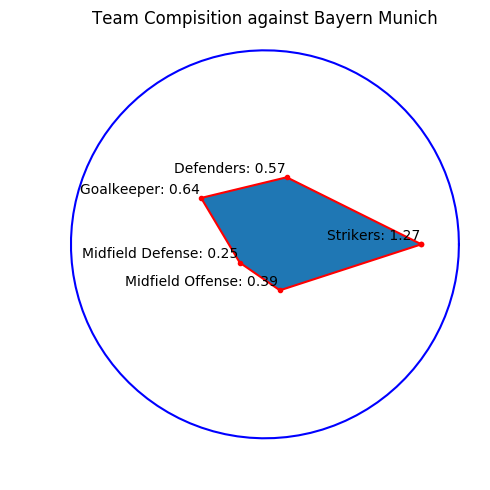

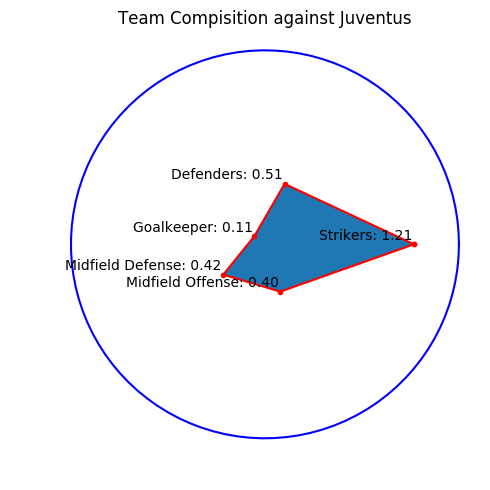

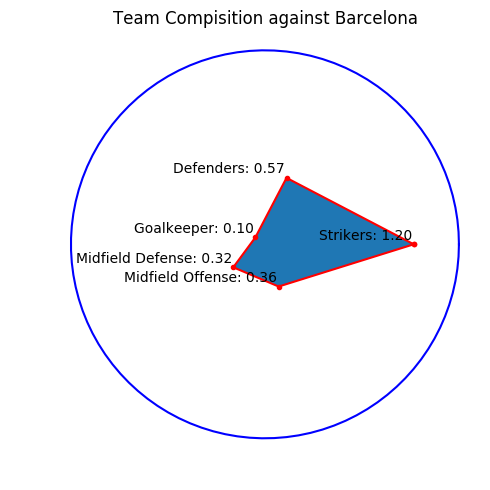

In [59]:
#Visualize the scores for each match
match_offenses = Array{Float64}(zeros(matches))
match_defenses = Array{Float64}(zeros(matches))
match_goalkeeper = Array{Float64}(zeros(matches))
match_md_offenses = Array{Float64}(zeros(matches))
match_md_defenses = Array{Float64}(zeros(matches))
for i in 1:matches
    #We omit including the scores as variables in the model to help with solving time, so the scores are given here instead
    if i == 1
    match_offenses[i] = atan((sum(sum(season_comps[i,j,3]*str_vals[j,:]) for j=1:25))/max_offense)
    match_defenses[i] = atan((sum(sum(season_comps[i,j,2]*def_vals[j,:]) for j=1:25))/max_defense)
    match_goalkeeper[i] = atan((sum(sum(season_comps[i,j,1]*gk_vals[j,:]) for j=1:25))/max_gk)
    match_md_offenses[i] = atan((sum(sum(season_comps[i,j,4]*md_off_vals[j,:]) for j=1:25))/max_md_off)
    match_md_defenses[i] = atan((sum(sum(season_comps[i,j,4]*md_def_vals[j,:]) for j=1:25))/max_md_def)
    else
    match_offenses[i] = atan((sum(sum(season_comps[i,j,3]*str_vals[j,:])*(1-sum(season_comps[i-1,j,l] for l=1:4)*stamina[j]) for j=1:25))/max_offense)
    match_defenses[i] = atan((sum(sum(season_comps[i,j,2]*def_vals[j,:])*(1-sum(season_comps[i-1,j,l] for l=1:4)*stamina[j]) for j=1:25))/max_defense)
    match_goalkeeper[i] = atan((sum(sum(season_comps[i,j,1]*gk_vals[j,:])*(1-sum(season_comps[i-1,j,l] for l=1:4)*stamina[j]) for j=1:25))/max_gk)
    match_md_offenses[i] = atan((sum(sum(season_comps[i,j,4]*md_off_vals[j,:])*(1-sum(season_comps[i-1,j,l] for l=1:4)*stamina[j]) for j=1:25))/max_md_off)
    match_md_defenses[i] = atan((sum(sum(season_comps[i,j,4]*md_def_vals[j,:])*(1-sum(season_comps[i-1,j,l] for l=1:4)*stamina[j]) for j=1:25))/max_md_def)
    end
end
for i in 1:matches
    radii = Array{Float64}(zeros(6))
    radii[1] = match_offenses[i]
    radii[2] = match_defenses[i]
    radii[3] = match_goalkeeper[i]
    radii[4] = match_md_defenses[i]
    radii[5] = match_md_offenses[i]
    radii[6] = match_offenses[i]
    angles = [0; 2π/5; 4π/5; 6π/5; 8π/5; 10π/5;]
    t = linspace(0,2π,100)
    figure(figsize=[5,5])
    plot( (π/2)*cos(t), (π/2)*sin(t), "b-" )
    plot( radii.*cos(angles), radii.*sin(angles), "r.-" )
    fill_between(radii.*cos(angles), 0, radii.*sin(angles))
    if i == 1
        title("Team Compisition against Bayern Munich")
    end
    if i == 2
        title("Team Compisition against Juventus")
    end
    if i == 3
        title("Team Compisition against Barcelona")
    end
    label = ["Strikers", "Defenders", "Goalkeeper", "Midfield Defense", "Midfield Offense"]
    for j in 1:5
            annotate(label[j] * ": " * @sprintf("%.2f",radii[j]),
            xy=[radii[j]*cos(angles[j]); radii[j]*sin(angles[j])],
            xycoords = "data",
            xytext=[-1, 1],
        textcoords="offset points", ha="right", va="bottom")
        #arrowprops=["facecolor"=>"black"]);
    end
    axis("equal");axis("off");tight_layout();
end